# Data simulation and model comparison

In this notebook I will simulate data based on the risk and ambiguity task in the aging experiment.

In this version of the task there are 84 trials.

Values: 5, 8, 12, 25

Risk: 0.25, 0.5, 0.75

Ambiguity: 0, 0.24, 0.5, 0.74


## Libraries that will be used in the experiment

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy.special import expit
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az
import cmdstanpy

import matplotlib.pyplot as plt
import seaborn as sns

## Load data and simulate participants choices

This file includes all the trials w/o choices

In [2]:
db = pd.read_csv('data/sim.csv')

Here we declare how many participants will be simulated.

risk aversion (α) is taken from a beta distribution with a mean of 0.33, and then multiply by 2 for a final mean of 0.66 (medium risk aversion).

Ambiguity aversion (β) is taken from a truncated normal distribution between -1.5 and 1.5 with a 0.3 average (slight ambiguity aversion).


In [3]:
n_subs = 20

α_true = np.random.beta(2, 4, n_subs)
α_true = α_true * 2
β_true = stats.truncnorm.rvs(-1.5, 1.5, 0.3, size = n_subs)

value     = np.tile(np.array(db.value),     n_subs)
risk      = np.tile(np.array(db.risk),      n_subs)
ambiguity = np.tile(np.array(db.ambiguity), n_subs)
# noise_sd = 3 # the SD in a normal disterbution mean 0 added to the selection probabilty

In [4]:
refValue       = 5 # constant
refProbability = 1 # constant
refAmbiguity   = 0 # constant

refProbabilities = np.tile(refProbability, len(value))
refValue         = np.tile(refValue,       len(value))
refAmbiguities   = np.tile(refAmbiguity,   len(value))

In [5]:
riskTol = np.repeat(α_true, len(risk) / n_subs)
ambTol  = np.repeat(β_true, len(ambiguity) / n_subs)

Simulate choice base on the utility function 

In [6]:
uRef = refValue ** riskTol
uLotto = (value ** riskTol) * (risk - (ambTol * ambiguity / 2))
p = sp.special.expit(uLotto - uRef)

choice = np.random.binomial(1, p, len(p))

In [7]:
sub_idx = np.arange(n_subs)
sub_idx = np.repeat(sub_idx, 84)
ID = sub_idx+1
n_trials = np.arange(len(choice))

Create a simulation dataframe 

In [8]:
simdata = pd.DataFrame({'sub': ID, 'choice': choice, 'value': value, 'risk': risk, 'ambiguity': ambiguity, 'riskTol': riskTol, 'ambTol': ambTol})
# simdata.to_csv('results/simdata.csv')
df = simdata
simdata.head()

,sub,choice,value,risk,ambiguity,riskTol,ambTol
0,1,0,5,0.25,0.00,0.832915,0.706413
1,1,0,5,0.50,0.50,0.832915,0.706413
2,1,0,12,0.50,0.74,0.832915,0.706413
3,1,1,25,0.50,0.74,0.832915,0.706413
4,1,0,8,0.50,0.50,0.832915,0.706413


## Maximum Likelihood

The first approach I will test is Maximum likelihood. 

In [9]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    
    svLotto = (df_mle['value'].values ** α) * (df_mle['risk'].values - (β * (df_mle['ambiguity'].values/2)))
    svRef = 5 ** α
    #p = 1/(1+np.exp((svRef - svLotto) * γ))
    p = sp.special.expit((svLotto - svRef)* γ)

    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(df_mle.choice, p))
    
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

def MLE_analysis():
    mle_model = minimize(MLE_riskamb, np.array([0.5,0.5,1]), method='L-BFGS-B', bounds=[(0,2),(-1.5,1.5),(-np.inf,np.inf)])
    x = mle_model.x
    return x

In [10]:
subs = df['sub'].unique()
mLL = pd.DataFrame()
for sub in subs:
    df_mle = df[df['sub'] == sub]
    x = MLE_analysis()
    temp = {'sub': sub, 'alpha' : x[0], 'beta': x[1], 'gamma': x[2]}
    mLL = mLL.append(temp,ignore_index=True)

In [11]:
mLL['α_true'] = α_true
mLL['β_true'] = β_true
mLL['∆α'] = mLL.alpha - mLL.α_true
mLL['∆β'] = mLL.beta - mLL.β_true
mLL.head()

,alpha,beta,gamma,sub,α_true,β_true,∆α,∆β
0,0.906128,1.069919,3.979092,1.0,0.832915,0.706413,0.073213,0.363506
1,0.872884,-0.507062,0.882205,2.0,0.842779,-0.466584,0.030106,-0.040479
2,1.593390,0.585140,9.707562,3.0,1.705190,0.706599,-0.111800,-0.121459
3,0.861195,1.172313,1.088018,4.0,0.847346,0.686274,0.013849,0.486039
4,0.196518,-1.500000,2.518404,5.0,0.334549,-0.709973,-0.138031,-0.790027


## Next we will look at PYMC3

In [12]:
def pymc_model (df_p, sub_idx, n_subs, ppc = False):

    with pm.Model() as RiskAmb:
        # Hyper Priors
        a = pm.Poisson('a', 1)
        b = pm.Poisson('b', 1)

        bMu = pm.Normal('bMu', 0,1)
        bSig = pm.Exponential('bSig', 1)

        gMu = pm.Normal('gMu', 0,1)
        gSig = pm.Exponential('gSig', 1)

        # Priors for unknown model parameters
        α_raw = pm.Beta('α_raw', a, b, shape = n_subs)
        α = pm.Deterministic('α', 2 * α_raw)
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
        γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)



        # Expected value of outcome
        svLotto = (df_p['value'].values ** α[sub_idx]) * (df_p['risk'].values - (β[sub_idx] * (df_p['ambiguity'].values/2)))
        svRef = 5 ** α[sub_idx]
        p = (svLotto - svRef)/γ[sub_idx]
        mu = pm.invlogit(p)

        # Likelihood (sampling distribution) of observations
        choice = pm.Binomial('choice',1, mu, observed=df_p['choice'])
        trace = pm.sample(1000, return_inferencedata=True,  nuts={'target_accept':0.99})
    if ppc:    
        with RiskAmb:   
            ppc = pm.sample_posterior_predictive(trace)
        return (trace, ppc, RiskAmb)
    return (trace)

In [13]:
def pymc_model2 (df, sub_idx, n_subs, ppc = False):
    with pm.Model() as RiskAmb:
        aMu = pm.Normal('rMu', 0.7 ,1)
        aSig = pm.Exponential('rSig', 1)
        bMu = pm.Normal('aMu', 0,1)
        bSig = pm.Exponential('aSig', 1)

        gMu = pm.Normal('nMu', 0,1)
        gSig = pm.Exponential('nSig', 1)


        α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
        γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
        # Priors for unknown model parameters


        # Expected value of outcome
        svLotto = (df['value'].values ** α[sub_idx]) * (df['risk'].values - (β[sub_idx] * (df['ambiguity'].values/2)))
        svRef = 5 ** α[sub_idx]
        p = (svLotto - svRef)/γ[sub_idx]
        mu = pm.invlogit(p)

        # Likelihood (sampling distribution) of observations
        choice = pm.Binomial('choice',1, mu, observed=simdata['choice'])
        trace = pm.sample(4000, return_inferencedata=True, target_accept=0.99)
    if ppc:    
        with RiskAmb:   
            ppc = pm.sample_posterior_predictive(trace)
        return (trace, ppc, RiskAmb)
    return (trace)

In [14]:
trace, ppc, model = pymc_model(df, sub_idx, n_subs, ppc = True)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 330 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

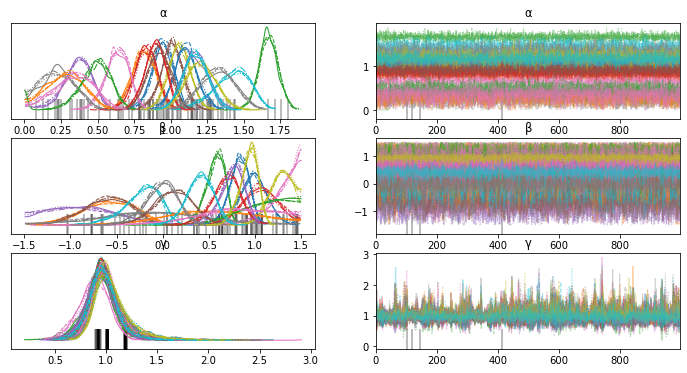

In [15]:
az.plot_trace(trace, var_names=['α','β','γ'])

<AxesSubplot:xlabel='choice / choice'>

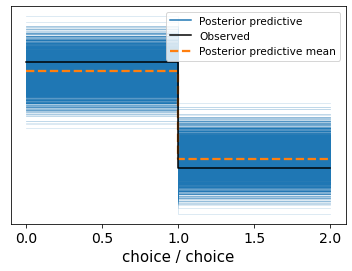

In [16]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

In [17]:
α_pymc = az.summary(trace, var_names=['α'])['mean']
β_pymc = az.summary(trace, var_names=['β'])['mean']
γ_pymc = az.summary(trace, var_names=['γ'])['mean']

outcome = pd.DataFrame({'subs':subs,
                        'α_true': α_true, 'α_pymc': α_pymc.values, 'α_MLL': mLL.alpha.values,
                        'β_true': β_true, 'β_pymc': β_pymc.values, 'β_MLL': mLL.beta.values,
                                          'γ_pymc': γ_pymc.values, 'γ_MLL': mLL.gamma.values})


In [18]:
outcome.corr()

,subs,α_true,α_pymc,α_MLL,β_true,β_pymc,β_MLL,γ_pymc,γ_MLL
subs,1.000000,0.124938,0.082575,0.151509,0.198862,0.176420,0.203313,0.288241,-0.444468
α_true,0.124938,1.000000,0.975145,0.959669,0.215950,0.119877,0.255504,0.053863,0.373388
α_pymc,0.082575,0.975145,1.000000,0.979539,0.123767,0.046659,0.165329,0.113528,0.371242
α_MLL,0.151509,0.959669,0.979539,1.000000,0.106013,0.054291,0.202962,0.250944,0.255175
β_true,0.198862,0.215950,0.123767,0.106013,1.000000,0.938492,0.883289,-0.471977,0.152003
β_pymc,0.176420,0.119877,0.046659,0.054291,0.938492,1.000000,0.958349,-0.318468,0.102700
β_MLL,0.203313,0.255504,0.165329,0.202962,0.883289,0.958349,1.000000,-0.222187,0.062963
γ_pymc,0.288241,0.053863,0.113528,0.250944,-0.471977,-0.318468,-0.222187,1.000000,-0.471048
γ_MLL,-0.444468,0.373388,0.371242,0.255175,0.152003,0.102700,0.062963,-0.471048,1.000000


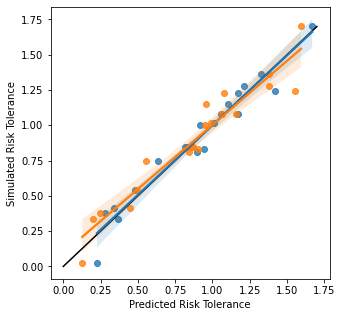

In [19]:
xmax = max(outcome.α_true)
x = np.arange(0, xmax, .05)
y = x

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(y, x, color='black')

sns.regplot(data=outcome, x='α_pymc', y='α_true', ax=ax)
sns.regplot(data=outcome, x='α_MLL',  y='α_true', ax=ax)
ax.set(xlabel="Predicted Risk Tolerance", ylabel="Simulated Risk Tolerance")

plt.show()

## Plot regression line

In [20]:
prop = df.groupby(['sub','ambiguity','risk','value'], as_index=False)['choice'].mean()
prop.head()

,sub,ambiguity,risk,value,choice
0,1,0.0,0.25,5,0.00
1,1,0.0,0.25,8,0.00
2,1,0.0,0.25,12,0.25
3,1,0.0,0.25,25,0.75
4,1,0.0,0.50,5,0.00


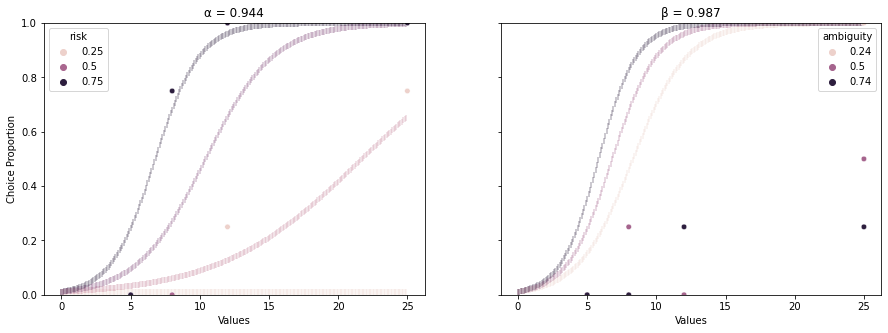

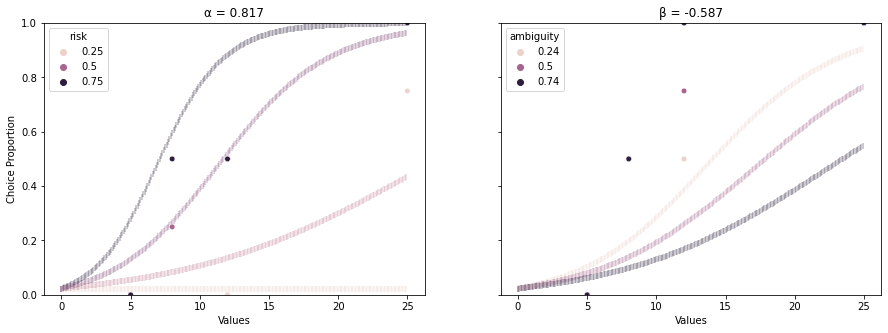

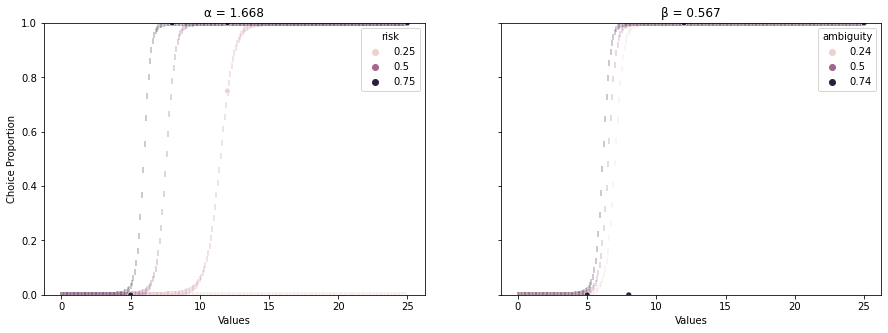

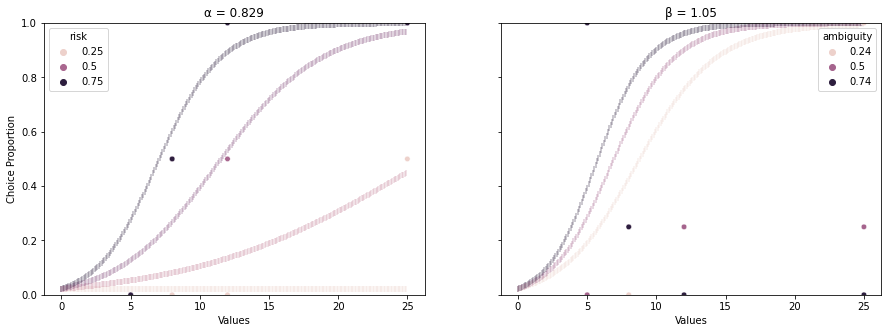

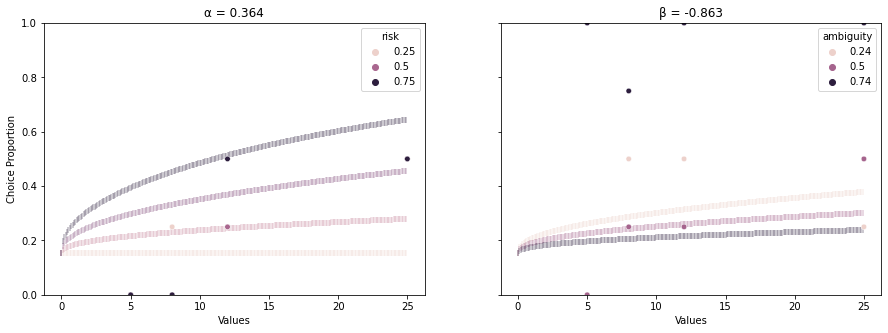

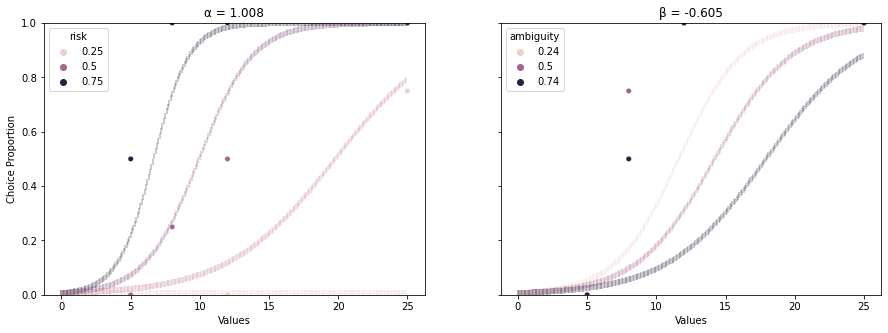

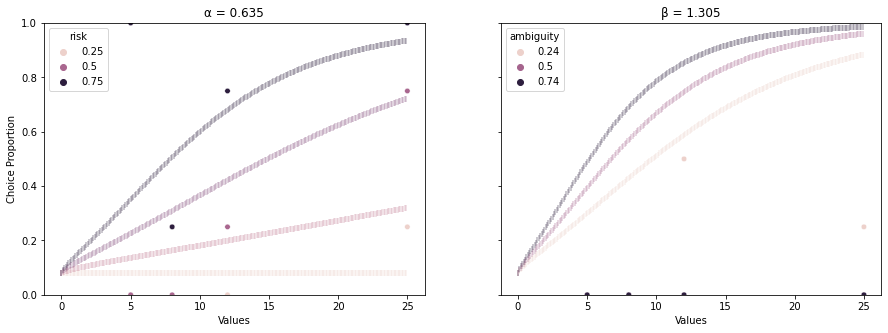

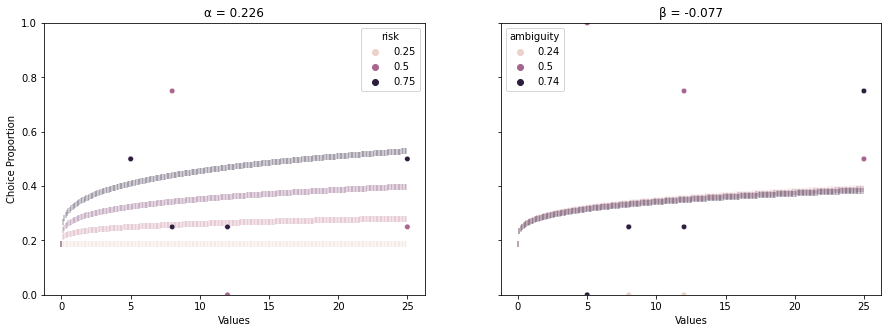

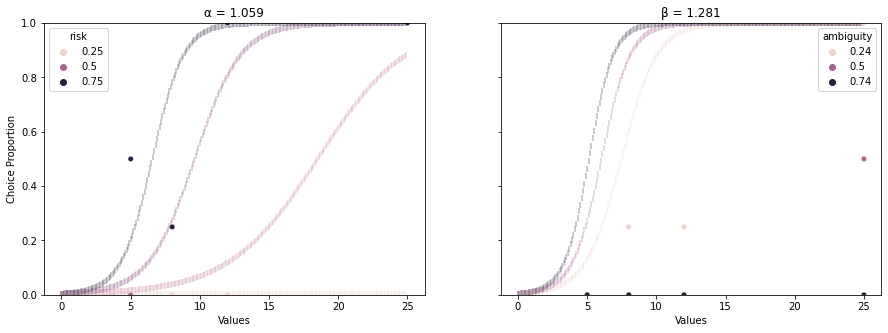

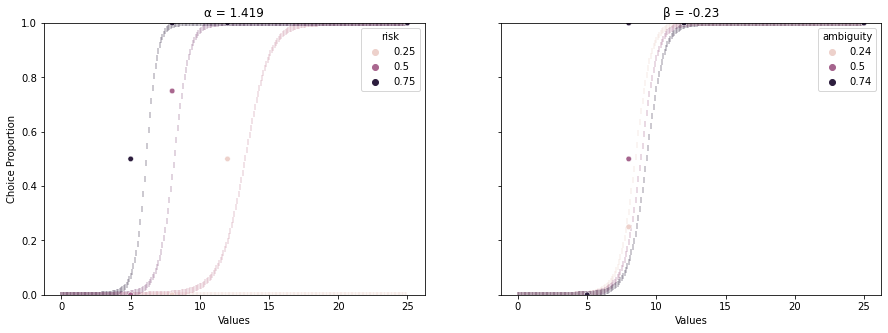

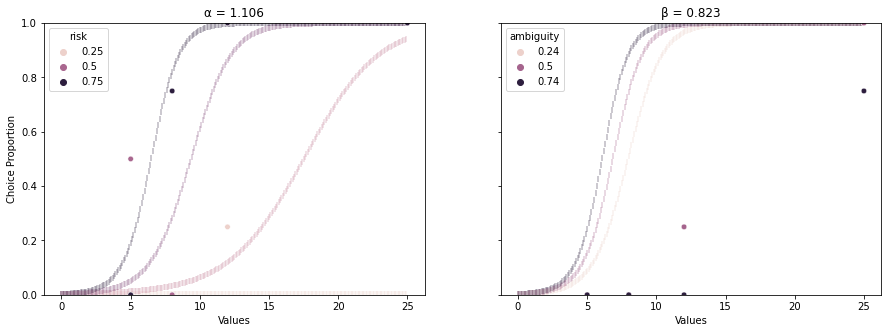

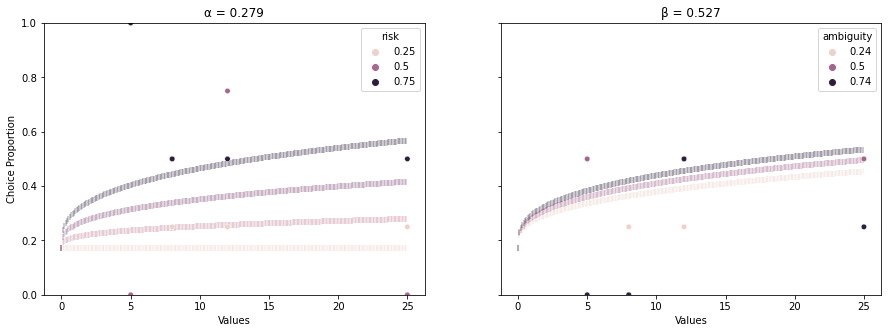

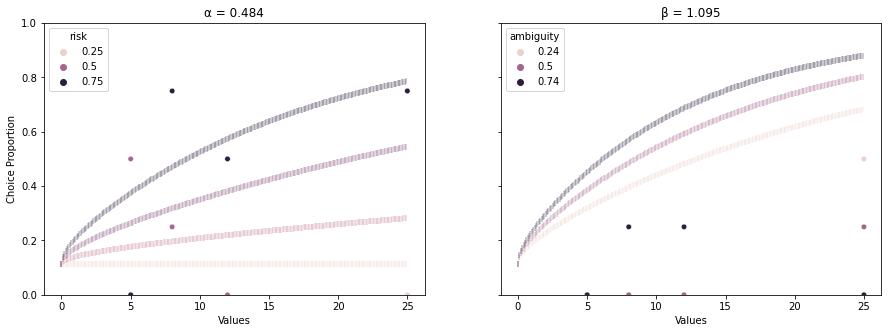

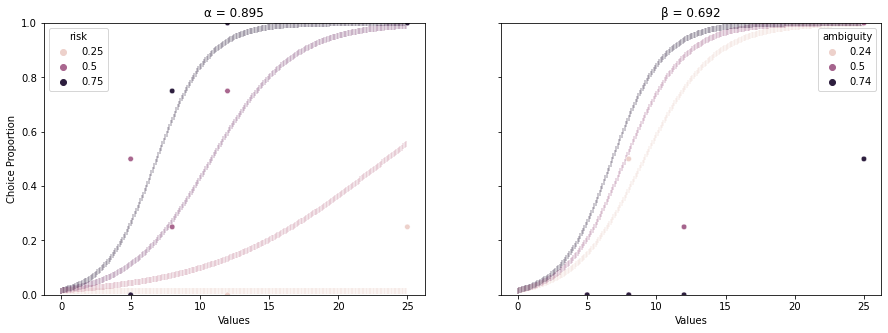

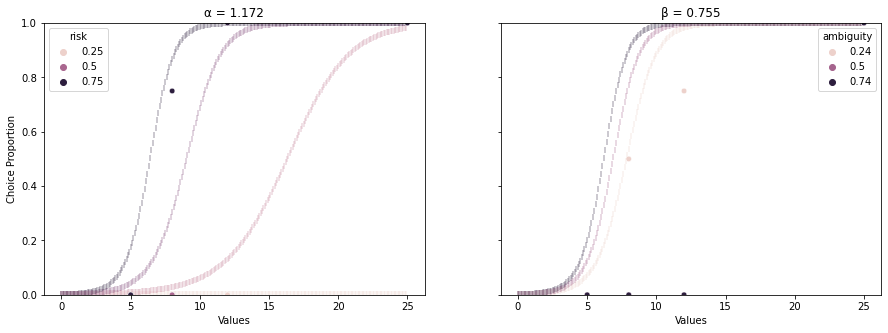

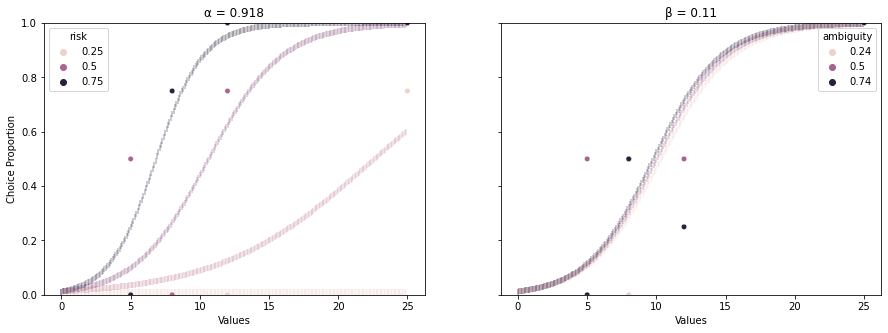

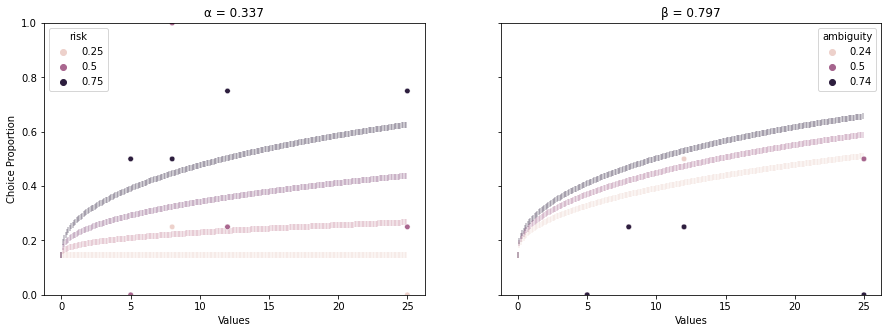

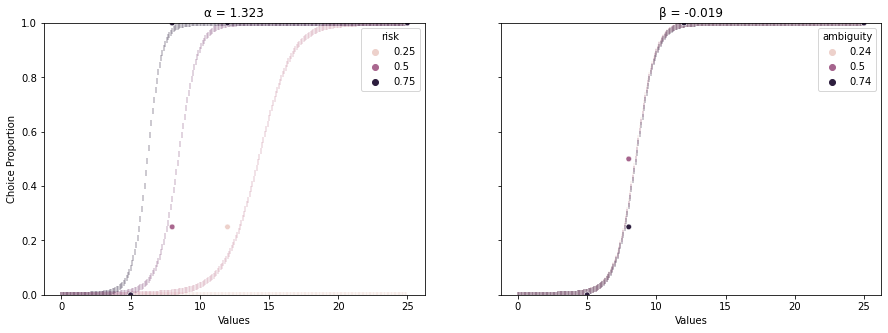

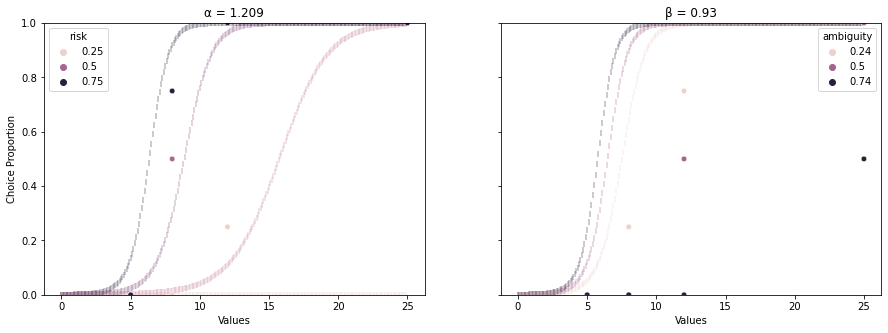

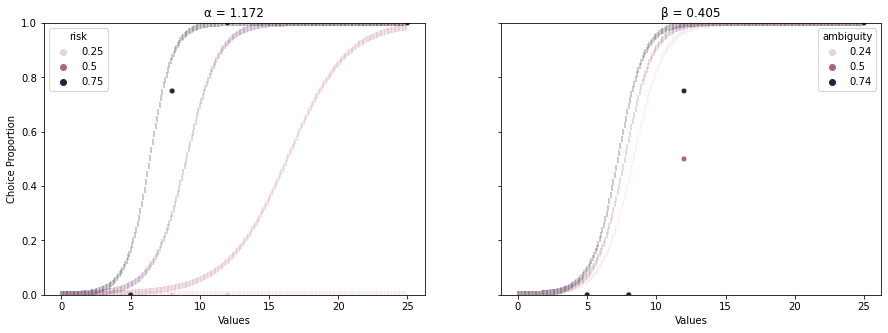

In [24]:
risks     = [0, 0.25, 0.5, 0.75]
ambiguity = [0.24, 0.5, 0.74]

for sub in subs:
    
    figR=pd.DataFrame()
    figA=pd.DataFrame()
    
    f, ax = plt.subplots(1, 2, figsize=(15, 5),sharey=True)

    alpha  = float(outcome[outcome['subs']==sub]['α_pymc'])
    beta   = float(outcome[outcome['subs']==sub]['β_pymc'])
    gamma  = float(outcome[outcome['subs']==sub]['γ_pymc'])
    
    for value in np.arange(0, 25, 0.1):
        for risk in risks:
            svLotto = risk * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'risk':risk}, index=[0])
            figR = figR.append(temp)
        
        for amb in ambiguity:
            svLotto = (0.5 + beta * amb/2) * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'ambiguity':amb}, index=[0])
            figA = figA.append(temp)
        
    sns.scatterplot(x='x', y='y', data=figR, hue='risk', ax=ax[0], legend = False, marker="|")  
    sns.scatterplot(x='x', y='y', data=figA, hue='ambiguity', ax=ax[1], legend = False, marker="|") 
    
    fig = prop[prop['sub']==sub]
    figR = fig[fig['ambiguity']==0]
    figA = fig[fig['ambiguity'] > 0]
    
    sns.scatterplot(x='value', y='choice', data=figR, hue='risk', ax=ax[0], s=30)
    sns.scatterplot(x='value', y='choice', data=figA, hue='ambiguity', ax=ax[1], s=30)
    
    ax[0].set(xlabel="Values", ylabel="Choice Proportion", title="α = {}".format(alpha), ylim=(0,1))
    ax[1].set(xlabel="Values", title="β = {}".format(beta))
    plt.show()

# Sensitivity analysis

add random noise to the probability to look at how it effect the model ability to derive the alpha and beta parameters 

In [33]:
len()

1680

In [35]:
sensitivity = pd.DataFrame()
value = df.value.to_list()
risk = df.risk.to_list()
ambiguity = df.ambiguity.to_list()

noise_level = range(1,11)

for noise_sd in noise_level:
    noise = np.random.lognormal(0, noise_sd, len(uRef))
    p = sp.special.expit((uLotto - uRef) * noise)

    choice = np.random.binomial(1, p, len(p))
    simdata = pd.DataFrame({'sub': ID, 'choice': choice, 'value': df.value.to_list(), 
                            'risk': risk, 'ambiguity': ambiguity, 'riskTol': riskTol, 'ambTol': ambTol})
    
    subs = simdata['sub'].unique()
    mLL = pd.DataFrame()
    for sub in subs:
        df_mle = simdata[simdata['sub'] == sub]
        x = MLE_analysis()
        temp = {'sub': sub, 'alpha' : x[0], 'beta': x[1], 'gamma': x[2]}
        mLL = mLL.append(temp,ignore_index=True)
        
    trace = pymc_model(simdata, sub_idx, n_subs)
    
    
    α_pymc = az.summary(trace, var_names=['α'])['mean']
    β_pymc = az.summary(trace, var_names=['β'])['mean']
    
    r2α = np.corrcoef(α_pymc, α_true)[0][1]**2
    r2β = np.corrcoef(β_pymc, β_true)[0][1]**2
    mllr2α = np.corrcoef(mLL.alpha, α_true)[0][1]**2
    mllr2β = np.corrcoef(mLL.beta, β_true)[0][1]**2
    
    temp = pd.DataFrame({"noise": noise_sd, "r2α": r2α, "r2β": r2β, "mllr2α": mllr2α, "mllr2β": mllr2β}, index=[0])
    sensitivity = sensitivity.append(temp)
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 408 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9692873811902285, but should be close to 0.99. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9686917149911121, but should be close to 0.99. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 600 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There were 983 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.006434084673224757, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [b]
>>Metropolis: [a]
>NUTS: [γ, β, α_raw, gSig, gMu, bSig, bMu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9576256843035124, but should be close to 0.99. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [36]:
sensitivity

,noise,r2α,r2β,mllr2α,mllr2β
0,1,0.940504,0.818721,0.912019,0.753437
0,2,0.854599,0.626045,0.856555,0.482153
0,3,0.818850,0.648756,0.861999,0.710710
0,4,0.640164,0.472811,0.748318,0.570710
0,5,0.810912,0.567970,0.868985,0.524974
0,6,0.805223,0.505766,0.838700,0.697532
0,7,0.723282,0.584105,0.551055,0.335035
0,8,0.899971,0.639546,0.856522,0.720638
0,9,0.742575,0.473202,0.739661,0.465367
0,10,0.656194,0.252326,0.745118,0.411401


<AxesSubplot:xlabel='noise', ylabel='r2α'>

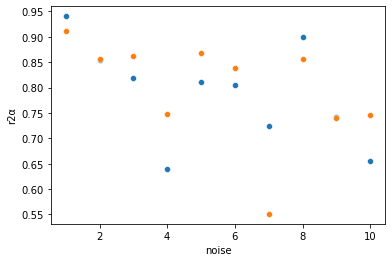

In [37]:
sns.scatterplot(data=sensitivity, x='noise', y="r2α")
sns.scatterplot(data=sensitivity, x='noise', y="mllr2α")

<AxesSubplot:xlabel='noise', ylabel='r2β'>

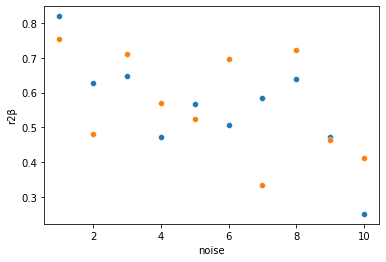

In [38]:
sns.scatterplot(data=sensitivity, x='noise', y="r2β")
sns.scatterplot(data=sensitivity, x='noise', y="mllr2β")